Join the data from Part 1 with the data from Part 2 to create a new dataframe.

In [3]:
# Imports
import pandas as pd
import numpy as np
import requests
import os
import json

# Load CSVs from previous notebooks
bikes_df = pd.read_csv('bikes_df.csv')
final_yelp_df = pd.read_csv('final_yelp_df.csv')
final_fsq_df = pd.read_csv('final_fsq_df.csv')

# Merge Yelp and Foursquare data
poi_info = pd.merge(final_fsq_df, final_yelp_df, how='outer')

# Drop unwanted/unneeded columns and remove duplicates
poi_info = poi_info.drop(columns=['fsq_id', 'category']).drop_duplicates()

# Change column names for easier reference and proper merge
poi_info = poi_info.rename(columns={'name': 'poi_name',
                                    'bike_station_lat': 'latitude',
                                    'bike_station_long': 'longitude'})

# Fill missing 'rating' values based on Yelp ratings
poi_info.loc[poi_info['rating'].isnull(), 'rating'] = poi_info['yelp_rating'] / 5 * 100 / 10
poi_info.loc[poi_info['rating'] == 10, 'rating'] = 9.3

# Drop rows with missing 'rating' values
drop_index = poi_info[(poi_info['rating'].isnull())].index
poi_info.drop(drop_index, axis=0, inplace=True)
poi_info = poi_info.drop('yelp_rating', axis=1)

# Rename columns in 'bikes_df'
bikes_df = bikes_df.rename(columns={'name': 'station_address'})

# Merge bike station data with merged POI data
station_poi_df = pd.merge(poi_info, bikes_df)

# Select specific columns for the final DataFrame
station_poi_df = station_poi_df[['station_address',
                                 'free_bikes',
                                 'poi_name',
                                 'address',
                                 'hours',
                                 'rating',
                                 'popularity(0-1)',
                                 'review_count',
                                 'distance']]

# Save the resulting DataFrame to a CSV file
station_poi_df.to_csv('station_poi_df.csv', index=False)

# Display the resulting DataFrame
station_poi_df


,station_address,free_bikes,poi_name,address,hours,rating,popularity(0-1),review_count,distance
0,Imperial & 7th,7,Everson Rocye Bar,1936 E 7th St,Open Daily 12:00 AM-2:00 AM,9.1,0.966693,555.0,134.0
1,Imperial & 7th,7,Little Bear L.A. Restaurant,1855 Industrial St,Wed-Thu 4:00 PM-10:00 PM; Fri-Sun 1:00 PM-10:0...,8.4,0.973154,555.0,170.0
2,Imperial & 7th,7,Bar Mateo,580 Mateo St,Open Daily 9:00 AM-9:00 PM,7.3,0.878875,555.0,532.0
3,Imperial & 7th,7,Market Place Restaurant,1102 Lawrence St,Mon-Fri 6:00 AM-2:00 PM; Sat 7:00 AM-1:30 PM,7.5,0.907987,555.0,669.0
4,Imperial & 7th,7,Rapp Bar Dtla,1318 E 7th St,"Mon-Wed 11:00 AM-3:00 PM, 4:00 PM-9:00 PM; Thu...",8.0,0.963334,555.0,919.0
...,...,...,...,...,...,...,...,...,...
2119,Magnolia & Clybourn,5,The Bullet,10522 Burbank Blvd,NaN,8.0,0.956762,105.0,469.5
2120,Magnolia & Clybourn,5,The Other Door,10437 Burbank Blvd,NaN,8.0,0.956762,264.0,469.5
2121,Magnolia & Clybourn,5,Tequilas Cantina & Grill,4310 W Magnolia Blvd,NaN,7.0,0.956762,590.0,469.5
2122,Magnolia & Clybourn,5,The Snug,4108 W Magnolia Blvd,NaN,8.0,0.956762,212.0,469.5


Provide a visualization that you used as part of your EDA process. Explain the initial pattern or relationship you discoved through this visualization. 

<Axes: xlabel='review_count', ylabel='free_bikes'>

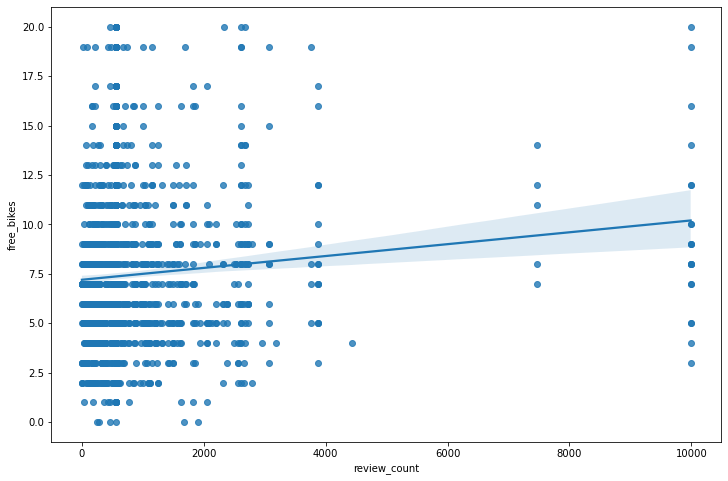

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.gcf()
fig.set_size_inches(12, 8)
sns.regplot(data = station_poi_df, x =station_poi_df['review_count'], y=station_poi_df['free_bikes'])

There appears to be a modest correlation between the quantity of available free bikes and the number of reviews recorded in the 'review_count' column.

# Database

Put all your results in an SQLite3 database (remember, SQLite stores its databases as files in your local machine - make sure to create your database in your project's data/ directory!)

In [ ]:
# Imports
import sqlite3
from sqlite3 import Error
import pandas as pd

# Read data from CSV file into a DataFrame
station_poi_df = pd.read_csv('/Users/jordankanius/Downloads/station_poi_df')

# Define a function to create a connection to the database
def create_connection(path):
    connection = None
    try:
        connection = sqlite3.connect(path)
        print("Connection to SQLite DB successful")
    except Error as e:
        print(f"The error '{e}' occurred")
    return connection

# Define a function to execute a SQL query
def execute_query(connection, query, params=None):
    cursor = connection.cursor()
    try:
        if params is None:
            cursor.execute(query)
        else:
            cursor.execute(query, params)
        connection.commit()
    except Error as e:
        print(f"The error '{e}' occurred")

# Define a function to execute a SQL query and retrieve results
def execute_read_query(connection, query):
    cursor = connection.cursor()
    result = None
    try:
        cursor.execute(query)
        result = cursor.fetchall()
        return result
    except Error as e:
        print(f"The error '{e}' occurred")

# Create a connection to the SQLite database
connection = create_connection('station_info.db')

# Define SQL queries to create tables if they don't exist
create_table_stations = '''
CREATE TABLE IF NOT EXISTS stations(
address VARCHAR(50) PRIMARY KEY,
free_bikes INTEGER)
'''

create_poi_table = '''
CREATE TABLE IF NOT EXISTS poi_info(
address VARCHAR(50),
poi_name VARCHAR(50),
poi_address VARCHAR(50),
hours VARCHAR(50),
CONSTRAINT fk_poi_info FOREIGN KEY (address) REFERENCES stations(address))
'''

create_poi_metrics = '''
CREATE TABLE IF NOT EXISTS poi_metrics(
address VARCHAR(50) UNIQUE,
rating FLOAT,
popularity FLOAT,
review_count INTEGER,
distance INTEGER,
CONSTRAINT fk_poi_metrics FOREIGN KEY (address) REFERENCES poi_info(poi_address))
'''

# Execute the SQL queries to create tables
execute_query(connection, create_table_stations)
execute_query(connection, create_poi_table)
execute_query(connection, create_poi_metrics)

# Prepare data for insertion into tables
station_entry = []
station_table = station_poi_df[['station_address' ,'free_bikes']].drop_duplicates()
for x in range(len(station_table)):
    dict = {
    'address' : station_table['station_address'].to_list()[x],
    'free_bikes': station_table['free_bikes'].to_list()[x]
    }
    station_entry.append(dict)

poi_entry = []
poi_table = station_poi_df[['station_address','poi_name', 'address', 'hours']]
for x in range(len(poi_table)):
    dict = {
    'address':poi_table['station_address'].to_list()[x],
    'poi_name': poi_table['poi_name'].to_list()[x],
    'poi_address': poi_table['address'].to_list()[x],
    'hours': poi_table['hours'].to_list()[x]
    }
    poi_entry.append(dict)

metrics_entry = []   
poi_metrics = station_poi_df[['address', 'rating','popularity(0-1)','review_count','distance']]
for x in range(len(poi_metrics)):
    dict ={
           'address':poi_metrics['address'].to_list()[x],
           'rating':poi_metrics['rating'].to_list()[x],
           'popularity':poi_metrics['popularity(0-1)'].to_list()[x],
           'review_count':poi_metrics['review_count'].to_list()[x],
           'distance':poi_metrics['distance'].to_list()[x]
          }
    metrics_entry.append(dict)

# Insert data into tables
for entry in station_entry:
    execute_query(connection, "INSERT or IGNORE INTO stations (address, free_bikes) VALUES(?,?)",
                                (entry['address'], entry['free_bikes']))

for entry in poi_entry:
    execute_query(connection, "INSERT or REPLACE INTO poi_info (address,poi_name, poi_address, hours) VALUES(?,?,?,?)",
                                (entry['address'], entry['poi_name'], entry['poi_address'], entry['hours']))

for entry in metrics_entry:
    execute_query(connection, "INSERT OR IGNORE INTO poi_metrics ( address, rating, popularity,review_count,distance) VALUES(?,?,?,?,?)",
                                (entry['address'], entry['rating'], entry['popularity'],entry['review_count'],entry['distance']))


Look at the data before and after the join to validate your data.

In [ ]:
# Perform a SQL query to select data from multiple tables by joining them
selection = pd.read_sql(
    "SELECT s.address, free_bikes, poi_name, poi_address, hours, rating, popularity, review_count, distance\
     FROM stations as s RIGHT OUTER JOIN poi_info as p ON s.address = p.address\
     LEFT OUTER JOIN poi_metrics AS po ON p.poi_address = po.address ", connection)

# Check if the shape of the selected data matches the shape of the original DataFrame
if selection.shape == station_poi_df.shape:
    print(True)

# Define a function to check the range of values in a specified column of a DataFrame
def range_check(dataframe, table, column):
    """
    Check if the range of values in a specified column of a DataFrame matches the range in a corresponding database table.

    Parameters:
    -----------
    dataframe : pandas DataFrame
        The DataFrame containing the data to be checked.

    table : str
        The name of the database table from which the values should be compared.

    column : str
        The name of the column within both the DataFrame and the database table to be compared.


    Notes:
    ------
    This function performs a range check by comparing the maximum and minimum values of the specified column
    in the DataFrame to the maximum and minimum values of the same column in the specified database table.
    It prints a message indicating whether the maximum and minimum values match, indicating that the ranges are equal.
    """
    value_check = pd.read_sql(f"SELECT {column} FROM {table}", connection)
    if dataframe[f'{column}'].max() == value_check.max()[0]:
        print("Max values before and after ranges are equal")
    if dataframe[f'{column}'].min() == value_check.min()[0]:
        print('Min values before and after ranges are equal')

# Perform range checks for specific columns and tables
range_check(station_poi_df, 'stations', 'free_bikes')
range_check(station_poi_df, 'poi_metrics', 'rating')
range_check(station_poi_df, 'poi_metrics', 'distance')
